# Deep Computer Vision Using Convolutional Neural Networks

Convolutional neural networks (CNNs) emerged from the study of the brain's visual cortex, and they have been used in image recognition since the 1980s. They power image search services, self-driving cars, automatic video classification systems, and more. Moreover, CNNs are not restricted to visual perception: they are also successful at many other tasks, such as voice recognition and natural language processing. In this chapter we will explore where CNNs came from, what their building blocks look like, and how to implement them using TensorFlow and Keras. Then we will discuss some of the best CNN architectures, as well as other visual tasks, including object detection (classifying multiple objects in an image and placing bounding boxes around them) and semantic segmentation (classifying each pixel according to the class of the object it belongs to).

## The Architecture of the Visual Cortex

Why not simply use a deep neural network with fully connected layers for image recognition tasks? Unfortunately, although this works fine for small images, it breaks down for larger images because of the huge number of parameters it requires. For example, a 100 x 100-pixel image has 10,000 pixels, and if the first layer has just 1000 neurons (which already severely restricts the amount of information transmitted to the next layer), this means a total of 10 million connections. And that's just the first layer. CNNs solve this problem using partially connected layers and weight sharing. 

## Convolutional Layers

The most important building block of a CNN is the *convolutional layer*. Neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in the layers discussed in previous chapters), but only to pixels in their receptive fields. In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. This architecture allows the network to concentrate on small low-level features in the next hidden layer, and so on. This hierarchical structure is common in real-world images, which is one of the reasons why CNNs work so well for image recognition. 

All the multilayer neural networks we've looked at so far had layers composed of a long line of neurons, and we had to flatten input images to 1D before feeding them to the neural network. In a CNN each layer is represented in 2D, which makes it easier to match neurons with their corresponding inputs.

In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs. This is called *zero padding*. It is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields. This dramatically reduces the model's computational complexity. The shift from one receptive field to the next is called the *stride*. **The stride does not have to be equal in all directions.**

## Filters

A neuron's weights can be represented as s small image the size of the receptive field. For example, consider two possible sets of weights, called *filters* (or *convolutional kernels*). The first one is represented as a black square with a vertical white line in the middle. Neurons using these weights will ignore everything in their receptive field except for the central vertical line. The second filter is a black square with a horizonal white line in the middle. Once again, neurons using these weights will ignore everything in their receptive field except for the central horizonal line.

Now if all neurons in a layer use the same vertical line filter and you feed the network an input image the vertical white lines in the image get enhanced while the rest gets blurred. Similarly, if all neurons use the same horizonal line filter the horizonal white lines get enhanced while the rest is blurred out. Thus, a layer full of neurons using the same filter outputs a *feature map*, which highlights the areas in an image that activate the filter the most. Of course, you do not have to define the filters manually: instead, during training the convolutional layer will automatically learn the most useful filters for its task, and the layers above will learn to combine them into more complex patterns.

## Stacking Multiple Feature Maps

A convolutional layer has multiple filters (you decide how many) and outputs one feature map per filter, so it is more accurately represented in 3D. It has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e. the same weights and bias term). In short, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

The fact that all neurons in a feature map share the same parameters dramatically reduces the number of parameters in the model. Once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location.In contrast, once a regular DNN has learned to recognize a pattern in one location, it can recognize it only in that particular location.

## TensorFlow Implementation

Let's look at a simple example

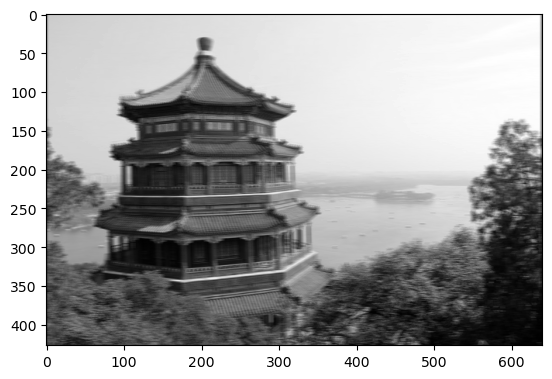

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[0, :, :, 1], cmap='gray') # plot 1st image's 2nd feature map
plt.show()

Let's go through this code:

1. The pixel intensity for each color channel is represented as a byte from 0 to 255, so we scale these features simply by dividing by 255, to get floats ranging from 0 to 1.
2. Then we create two 7x7 filters (one with a vertical white line in the middle and the other with a horizontal white line in the middle)
3. We apply them to both images uses the tf.nn.conv2d() function, which is part of TensorFlow's low-level Deep Learning API. In this example, we use zero padding (padding='SAME') and a stride of 2.
4. Finally, we plot one of the resulting feature maps

The tf.nn.conv2d() line deserves a bit more explanation:

1. images is the input mini-batch (a 4D tensor, as explained earlier).
2. filters is the set of filters to apply (also a 4D tensor, as explained earlier)
3. strides is equal to 1, but it could also be a 1D array with four elements, where the two central elements are the vertical and horizontal strides ($s_h$ and $s_w$). The first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layer's feature maps or channels).
4. padding must either be 'SAME' or 'VALID':
    - If set to 'SAME', the convolutional layer uses zero padding if necessary. The output size is set to the number of input neurons divided by the stride, rounded up. For example, if the input size is 13 and the stride is 5, then the output size is 3 (13 / 5 = 2.6 rounded up). Then zeros are added as evenly as possible around the inputs, as needed. **When strides=1, the layer's outputs will have the same spatial dimensions (width and height) as its inputs, hence the name 'SAME'**
    - If set to 'VALID', the convolutional layer does *not* use zero padding, and may ignore some rows and columns at hte bottom and right of the input image, depending on the stride. This means that every neuron's receptive field lies strictly within valid positions inside the input (it does not go out of bounds), hence the name *valid*

**In this example we manually defined the filters, but in a real CNN you would normally define filters as trainable variables so the neural net can learn which filters work best, as explained earlier.** Instead of manually creating the variables, us ethe keras.layers.Conv2D layer.

The following code creates a Conv2D layer with 32 filters, each 3x3, using a stride of 1 (both horizontally and vertically) and 'SAME' padding, and applying the ReLU activation function to its ouputs. We will discuss common CNN architectures later to give an idea of which hyperparameter values work best in practice.

In [2]:
conv = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='SAME',
    activation='relu'
)

## Memory Requirements

Another problem with CNNs is that the convolutional layers require a huge amount of RAM. This is especially true during training because the reverse pass of backpropagation requires all the intermediate valeus computed during the forward pass.

During inference (i.e. when making a prediction for a new instance) the RAM occupied by one layer can be released as soon as the next layer has been computed, so you only need as much RAM as required by two consecutive layers. But during training everything computed during the forward pass needs to be preserved for the reverse pass, so the amount of RAM needed is (at least) the total amount of RAM required by all layers.

**If training crashes because of an out-of-memory error, you can try reducing the mini-batch size. Alternatively, you can try reducing dimensionality using a stride, or removing a few layers. Or you can try using 16-bit floats instead of 32-bit floats. Or you could distribute the CNN across multiple devices.**

## Pooling Layers

Once you understand how convolutional layers work, the pooling layers are quite easy to grasp. Their goal is | Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. You must define its size, the stride, and the padding type, just like before. However, a pooling neuron has no weights; all it does is aggregate the inputs using an aggregation function such as the max or mean. The most common type of pooling layer is a *max pooling layer*. Only the max input value in each receptive field makes it to the next layer, while the other inputs are dropped.

A pooling layer typically works on every input channel independently, so the output depth is the same as the input depth. Other than reducing computations, memory usage, and the number of parameters, a max pooling layer also introduces some level of invariance to small translations. By inserting a max pooling layer every few layers in a CNN, it is possible to get some level of translation invariance at a larger scale. Morever, max pooling offers a small amount of rotational invariance and a slight scale invariance. Such invariance (even if its limited) can be useful in cases where the prediction should not depend on these details, such as in classification tasks.

However, max pooling has some downsides too. Firstly, it is obviously very destructive: even with a tiny 2x2 kernel a stride of 2, the output will be two times smaller in both directions (so its area will be four times smaller), simply dropping 75% of the input values. And in some applications, invariance is not desireable. Take semantic segmentation (the task of classifying each pixel in an image according to the object that pixel belongs to, which we'll explore later): obviously, if the input image is translated by one pixel to the right, the output should also be translated one pixel to the right. The goal in this case is *equivariance*, not invariance: a small change to the inputs should lead to a corresponding small change in the output.

## TensorFlow Implementation

Implementing a max pooling layer in TensorFlow is quite easy. The following code creates a max pooling layer and average pooling layer using a 2x2 kernel. As you might expect, the average pooling layer works exactly like the max pool laying, except it computes the mean rather than the max. Average pooling layers used to be very popular, but people mostly use the max pooling layers now, as they generally perform better. Max pooling preserves only the strongest features, getting rid of all the meaningless ones, so the next layers get a cleaner signal to work with. Moreover, max pooling offers stronger translation invariance than average pooling, and it requires slightly less compute.

Note that max pooling and average pooling can be performed along the depth dimension rather than the spatial dimensions, although this is not as common. This can allow the CNN to learn to be invariance to various features. For example, it could learn multiple filters, each detecting a different rotation of the same pattern (like digits), and the depthwise max pooling layer would ensure that the output is the same regardless of the rotation.

Keras does not include a depthwise max pooling layer, but TensorFlow's low-level Deep Learning API does; just use the tf.nn.max_pool() function, and specify the kernel size and strides as 4-tuples. The first three values of each should be 1: this indicates that the kernel size and stride along the batch, height, and widght dimensions should be 1. The last value should be whatever kernel size and stride you want along the depth dimension. If you want to include this as a layer in your models, wrap it in a Lambda layer (or create a custom Keras layer).

One last type of pooling layer that you will often see in modern architectures is the *global average pooling layer*. It works very differently: all it does is compute the mean of each entire feature map (it's like an average pooling layer using a pooling kernel with the same spatial dimensions as the inputs). This means that it just outputs a single number per feature map and per instance. Although this is of course extremely destructive (most of the information in the feature map is lost), it can be useful as the output layer, as we will see later. To create such a layer, simply use the GlobalAvgPool2D class.

In [3]:
# Max and Average pooling layers
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)
avg_pool = tf.keras.layers.AvgPool2D(pool_size=2)

In [4]:
# Depthwise pooling using TensorFlow low-level API
output = tf.nn.max_pool(
    images,
    ksize=(1, 1, 1, 3),
    strides=(1, 1, 1, 3),
    padding='VALID'
)

depth_pool = tf.keras.layers.Lambda(
    lambda X: tf.nn.max_pool(
        X,
        ksize=(1, 1, 1, 3),
        strides=(1, 1, 1, 3),
        padding='VALID'
    )
)

In [5]:
# Global average pooling
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

# Equivalently, this lambda function computes the mean over the spatial dimensions (height and width)
glbl_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2])
)

## CNN Architectures

Typical CNN architectures stack a few convolutional layers, then a pooling layer, then another few convolutional layers, then another pooling layer, and so on. At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers, and the final layer outputs the prediction.

**A common mistake is to use convolutional kernels that are too large.**  For example, instead of using a convolutional layer with a 5x5 kernel stack, stack two layers with 3x3 kernels: it will use fewer parameters and require fewer computations, and it will usually perform better. One exception is for the first convolutional layer: it can typically have a large kernel, usually with a stride of 2 or more: this will reduce the spatial dimension of the image without losing too much information, and since the input image only has three channels in general, it will not be too costly.

Below is an example implementing a simple CNN to tackle the Fashion MNIST dataset.

In [6]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess Fashion MNIST dataset
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Load dataset with batching and prefetching
dataset, info = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset = dataset['train'].map(preprocess_data).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess_data).batch(32).prefetch(tf.data.AUTOTUNE)

# Define model
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(64, 7, activation='relu', padding='same'),  # Use lowercase 'same'
    MaxPooling2D(2),
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(2),
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Fit model
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1875/1875 [==============================] - 170s 90ms/step - loss: 0.7253 - accuracy: 0.7423 - val_loss: 0.3729 - val_accuracy: 0.8643
Epoch 2/50
1875/1875 [==============================] - 157s 84ms/step - loss: 0.4158 - accuracy: 0.8572 - val_loss: 0.3606 - val_accuracy: 0.8670
Epoch 3/50
1875/1875 [==============================] - 154s 82ms/step - loss: 0.3571 - accuracy: 0.8776 - val_loss: 0.3212 - val_accuracy: 0.8903
Epoch 4/50
1875/1875 [==============================] - 150s 80ms/step - loss: 0.3221 - accuracy: 0.8903 - val_loss: 0.3284 - val_accuracy: 0.8896
Epoch 5/50
1875/1875 [==============================] - 146s 78ms/step - loss: 0.2917 - accuracy: 0.9011 - val_loss: 0.2991 - val_accuracy: 0.9011
Epoch 6/50
1875/1875 [==============================] - 153s 82ms/step - loss: 0.2795 - accuracy: 0.9043 - val_loss: 0.2977 - val_accuracy: 0.9009
Epoch 7/50
1875/1875 [==============================] - 148s 79ms/step - loss: 0.2617 - accuracy: 0.9086 - val_loss: 0

Let's walk through this model:

1. The first layer uses 64 fairly large filters (7x7) but no stride because the input images are not very large. The Input layer accepts 28x28 pixel images with a single color channel.
2. Next we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.
3. Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times (the number of repetitions is a hyperparameter you can tune).
4. **Note that the number of filters grows as we climb up the CNN toward the output layer (it is initially 64, then 128, then 256): it makes sense for it to grow, since the number of low-level features is often fairly low (e.g. small cirlces, horizontal lines), but there are many different ways to combine them into higher-level features.** It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear or exploding the number of parameters, memory usage, or computational load.
5. Next is the fully connected network, composed of two hidden dense layers and a dense output layer. Note that we must flatten its inputs, since a dense network expects ad 1D array of features for each instance. We also add two dropout layers, with a dropout rate of 50% each, to reduce overfitting.

Over the years, variants of this fundamental architecture have been developed, leading to amazing advances in the field.

### LeNet-5

The LeNet-5 architecture is perhaps the most widely known CNN architecture. It was created by LeCun in 1998

In [7]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, AvgPool2D, Flatten, Dense, Layer
from tensorflow.keras.callbacks import EarlyStopping

# Custom RBF Layer
class RBFLayer(Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = float(gamma)

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, axis=1) - tf.expand_dims(self.centers, axis=0)
        squared_dist = tf.reduce_sum(tf.square(diff), axis=-1)
        return tf.exp(-self.gamma * squared_dist)

# Optional Custom RBF Loss (Euclidean distance-based)
def rbf_loss(y_true, y_pred):
    # y_true: one-hot encoded labels [batch_size, 10]
    # y_pred: RBF outputs [batch_size, 10]
    # Minimize distance for correct class, maximize for others
    correct_class = tf.reduce_sum(y_true * y_pred, axis=-1)
    incorrect_class = tf.reduce_sum((1 - y_true) * y_pred, axis=-1)
    return tf.reduce_mean(incorrect_class - correct_class + 1.0)  # Margin of 1.0

# Preprocess Fashion MNIST dataset for LeNet-5
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.pad(image, [[2, 2], [2, 2], [0, 0]], mode='CONSTANT', constant_values=0)
    image = tf.ensure_shape(image, [32, 32, 1])
    label = tf.one_hot(label, depth=10)
    return image, label

# Load dataset
dataset, info = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset = dataset['train'].map(preprocess_data).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset['test'].map(preprocess_data).batch(128).prefetch(tf.data.AUTOTUNE)

# Define LeNet-5 model
model = Sequential([
    Input(shape=(32, 32, 1)),
    Conv2D(6, (5, 5), activation='tanh', padding='valid'),
    AvgPool2D((2, 2), strides=2),
    Conv2D(16, (5, 5), activation='tanh', padding='valid'),
    AvgPool2D((2, 2), strides=2),
    Flatten(),
    Dense(120, activation='tanh'),
    Dense(84, activation='tanh'),
    RBFLayer(10, gamma=1.0)
])

# Compile model
model.compile(
    optimizer='sgd',  # Use SGD for LeNet-5
    loss='categorical_crossentropy',  # Use categorical_crossentropy for one-hot labels
    # Alternative: loss=rbf_loss,  # Uncomment to use custom RBF loss
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Fit model
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
469/469 [==============================] - 16s 32ms/step - loss: 0.9407 - accuracy: 0.6733 - val_loss: 0.6959 - val_accuracy: 0.7506
Epoch 2/50
469/469 [==============================] - 14s 30ms/step - loss: 0.6223 - accuracy: 0.7726 - val_loss: 0.6052 - val_accuracy: 0.7771
Epoch 3/50
469/469 [==============================] - 16s 35ms/step - loss: 0.5590 - accuracy: 0.7958 - val_loss: 0.5608 - val_accuracy: 0.7924
Epoch 4/50
469/469 [==============================] - 15s 32ms/step - loss: 0.5219 - accuracy: 0.8110 - val_loss: 0.5303 - val_accuracy: 0.8055
Epoch 5/50
469/469 [==============================] - 15s 32ms/step - loss: 0.4948 - accuracy: 0.8229 - val_loss: 0.5073 - val_accuracy: 0.8161
Epoch 6/50
469/469 [==============================] - 14s 30ms/step - loss: 0.4738 - accuracy: 0.8309 - val_loss: 0.4892 - val_accuracy: 0.8253
Epoch 7/50
469/469 [==============================] - 16s 35ms/step - loss: 0.4568 - accuracy: 0.8379 - val_loss: 0.4747 - val_accuracy:

There are a few extra details to be noted:

1. MNIST images are 28x28 pixels, but they are zero-padded to 32x32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
2. The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again one per map), then finally applies the activation function.
3. The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.

### AlexNet

The AlexNet CNN architecture won the 2012 ImageNet ILSVRC challenge by a large margin. It is simliar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of one another, instead of stacking a pooling layer on top of each convolutional layer.

To reduce overfitting, the authors used two regularization techniques. First, they applied dropout with a 50% dropout rating during training to the outputs of the fully connected layers. second, they performed *data augmentation* by randomly shifting the training images by various offsets, flipping them horizontally, and changin the lighting conditions. AlexNet also uses a competitive normalization step immediately afte the ReLU steop of the first two convolutional layers, called *local response normalization (LRN)*: the most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps (such competitive action has been observed in biological neurons). This encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features, ultimately improving generalization. This step can be implemented using the tf.nn.local_response_normalization() function (which you can wrap in a Lambda layer if you want to use it in a Keras model).

$$\huge b_i = a_i\left(k + \alpha\displaystyle\sum_{j = j_{low}}^{j_{high}}a_j^2\right)^{-\beta}        with \huge \begin{cases} j_{high} = min(i + \frac{r}{2}, f_n - 1) \\ j_{low} = max(0, i - \frac{r}{2})\end{cases}$$

In this equation:

* $b_i$ is the normalized output of the neuron located in feature map i, at some row u and column v (note that in this equation we consider only neurons located at this row and column, so u and v are not shown).
* $a_i$ is the activation of that neuron afte the ReLU step, but before normalization.
* $k, \alpha, \beta, r$ are hyperparameters, k is called the bias, and r is called the depth radius.
* $f_n$ is the number of feature maps

In [8]:
''' Download the 150 GB ImageNet dataset to run this code block'''
# import tensorflow_datasets as tfds
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, Lambda
# from tensorflow.keras.callbacks import EarlyStopping

# # Basic preprocessing for ImageNet dataset
# def preprocess_data(image, label):
    
#     # Resize to 227x227 (direct crop for simplicity)
#     image = tf.image.resize(image, [227, 227])
    
#     # Normalize to [-1, 1]
#     image = tf.cast(image, tf.float32) / 127.5 - 1.0
#     label = tf.one_hot(label, depth=1000)  # ImageNet has 1000 classes
#     return image, label

# # Augment and extend dataset by generating multiple augmented versions
# def augment_and_extend_dataset(image, label, num_augmented=2):
#     images = [image]  # Include original image
#     labels = [label]  # Include original label
    
#     for _ in range(num_augmented):  # Generate num_augmented versions
#         aug_image = image
        
#         # Random augmentations
#         aug_image = tf.image.random_flip_left_right(aug_image)
#         aug_image = tf.image.random_brightness(aug_image, max_delta=0.2)
#         aug_image = tf.keras.preprocessing.image.random_rotation(
#             aug_image, rg=20, row_axis=0, col_axis=1, channel_axis=2
#         )
#         aug_image = tf.keras.preprocessing.image.random_shift(
#             aug_image, wrg=0.1, hrg=0.1, row_axis=0, col_axis=1, channel_axis=2
#         )
#         images.append(aug_image)
#         labels.append(label)
#     return tf.data.Dataset.from_tensor_slices((images, labels))

# # Load dataset
# dataset, info = tfds.load('imagenet2012', as_supervised=True, with_info=True)

# # Load dataset
# dataset, info = tfds.load('imagenet2012', as_supervised=True, with_info=True)
# train_dataset = dataset['train'].map(preprocess_data)
# train_dataset = train_dataset.flat_map(lambda x, y: augment_and_extend_dataset(x, y, num_augmented=2))
# train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
# test_dataset = dataset['validation'].map(preprocess_data).batch(128).prefetch(tf.data.AUTOTUNE)

# # Define AlexNet model
# model = Sequential([
#     Input(shape=(227, 227, 3)),
#     Conv2D(96, (11, 11), strides=4, activation='relu', padding='valid'),
#     Lambda(lambda x: tf.nn.local_response_normalization(
#         x, depth_radius=2, bias=1, alpha=0.00002, beta=0.75)),
#     MaxPool2D((3, 3), strides=2, padding='valid'),
#     Conv2D(256, (5, 5), activation='relu', padding='same'),
#     Lambda(lambda x: tf.nn.local_response_normalization(
#         x, depth_radius=2, bias=1, alpha=0.00002, beta=0.75)),
#     MaxPool2D((3, 3), strides=2, padding='valid'),
#     Conv2D(384, (3, 3), activation='relu', padding='same'),
#     Conv2D(384, (3, 3), activation='relu', padding='same'),
#     Conv2D(256, (3, 3), activation='relu', padding='same'),
#     Flatten(),
#     Dense(4096, activation='relu'),
#     Dropout(0.5),
#     Dense(4096, activation='relu'),
#     Dropout(0.5),
#     Dense(1000, activation='softmax')  # 1000 classes for ImageNet
# ])

# # Compile model
# model.compile(
#     optimizer='sgd',  # AlexNet typically uses SGD with momentum
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Define early stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# # Fit model
# history = model.fit(
#     train_dataset,
#     epochs=50,
#     validation_data=test_dataset,
#     callbacks=[early_stopping],
#     verbose=1
# )

' Download the 150 GB ImageNet dataset to run this code block'

### Data Augmentation

Data augmentation artifically increases the size of the training set by generating many realistic variants of each training instance. This reduces overfitting, making this a regularization technique. The generated instances should be as realistic as possible: ideally, given an image from the augmented training set, a human should not be able to tell whether it was augmented or not. Simply adding white noise will not help; the modifications should be learnable (white noise is not).

For example, you can slighty shift, rotate, and resize every picture in the training set by various amounts and add the resulting pictures to the training set. In general, you can also flip the pictures horizontally (except for text and other asymmetrical objects).

### GoogleNet

The GoogLeNet architecture won the ILSVRC 2014 challenge. This great performance came in large part from the fact that the network was much deeper than previous CNNs. This was made possible by subnetworks called *inception modules* which allow GoogLeNet to use parameters much more efficiently than previous architectures: GoogLeNet actually has 10 times fewer parameters than AlexNet (6M vs 60M).

You may wonder why inception modules have convolutional layers with 1x1 kernels. Surely these layers cannot capture any features because they look at only one pixel at a time? In fact, the layers serve three purposes:
1. Although they cannot capture spatial patterns, they can capture patterns along the depth dimension.
2. They are configured to output fewer feature maps than their inputs, so they serve as *bottleneck layers*, meaning they reduce the dimensionality. This cuts the computational cost and the number of parameters, speeding up training and improving generalization.
3. Each pair of convolutional layers ([1x1, 3x3] and [1x1, 5x5]) acts like a single powerful convolutional layer, capable of capturing more complex patterns. Indeed, **instead of sweeping a simple linear classifier across the image (as a single convolutional layer does), this pair of convolutional layers sweeps a two-layer neural network across the image.**

In short you can think of the whole inception module as a convolutional layer on steroids, able to output feature maps that capture complex patterns at various scales. The number of convolutional kernels for reach convolutional layer is a hyperparameter. Unfortunately, this means that **you have six more hyperparameters to tweak for every inception layer you add.**

In [ ]:
''' Download the 150 GB ImageNet dataset to run this code block'''
# import tensorflow_datasets as tfds
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D, AveragePooling2D
# from tensorflow.keras.callbacks import EarlyStopping

# # Basic preprocessing for ImageNet dataset
# def preprocess_data(image, label):
#     image = tf.image.resize(image, [227, 227])
#     image = tf.cast(image, tf.float32) / 127.5 - 1.0
#     label = tf.one_hot(label, depth=1000)
#     return image, label

# # Augment and extend dataset
# def augment_and_extend_dataset(image, label, num_augmented=2):
#     images = [image]
#     labels = [label]
#     for _ in range(num_augmented):
#         aug_image = image
#         aug_image = tf.image.random_flip_left_right(aug_image)
#         aug_image = tf.image.random_brightness(aug_image, max_delta=0.2)
#         aug_image = tf.keras.preprocessing.image.random_rotation(
#             aug_image, rg=20, row_axis=0, col_axis=1, channel_axis=2
#         )
#         aug_image = tf.keras.preprocessing.image.random_shift(
#             aug_image, wrg=0.1, hrg=0.1, row_axis=0, col_axis=1, channel_axis=2
#         )
#         images.append(aug_image)
#         labels.append(label)
#     return tf.data.Dataset.from_tensor_slices((images, labels))

# # Inception module
# def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool):
#     conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
#     conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
#     conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)
    
#     conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
#     conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)
    
#     pool = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
#     pool = Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(pool)
    
#     output = Concatenate()([conv_1x1, conv_3x3, conv_5x5, pool])
#     return output

# # Auxiliary classifier
# def auxiliary_classifier(x, num_classes=1000):
#     x = AveragePooling2D((5, 5), strides=3)(x)
#     x = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
#     x = Flatten()(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.7)(x)
#     x = Dense(num_classes, activation='softmax')(x)
#     return x

# # Load dataset
# dataset, info = tfds.load('imagenet2012', as_supervised=True, with_info=True)
# train_dataset = dataset['train'].map(preprocess_data)
# train_dataset = train_dataset.flat_map(lambda x, y: augment_and_extend_dataset(x, y, num_augmented=2))
# train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
# test_dataset = dataset['validation'].map(preprocess_data).batch(128).prefetch(tf.data.AUTOTUNE)

# # Define GoogLeNet model
# inputs = Input(shape=(227, 227, 3))
# x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
# x = MaxPool2D((3, 3), strides=2, padding='same')(x)
# x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
# x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
# x = MaxPool2D((3, 3), strides=2, padding='same')(x)

# # Inception modules
# x = inception_module(x, 64, 96, 128, 16, 32, 32)  # Inception 3a
# x = inception_module(x, 128, 128, 192, 32, 96, 64)  # Inception 3b
# x = MaxPool2D((3, 3), strides=2, padding='same')(x)
# x = inception_module(x, 192, 96, 208, 16, 48, 64)  # Inception 4a
# aux1 = auxiliary_classifier(x)  # Auxiliary classifier 1
# x = inception_module(x, 160, 112, 224, 24, 64, 64)  # Inception 4b
# x = inception_module(x, 128, 128, 256, 24, 64, 64)  # Inception 4c
# x = inception_module(x, 112, 144, 288, 32, 64, 64)  # Inception 4d
# aux2 = auxiliary_classifier(x)  # Auxiliary classifier 2
# x = inception_module(x, 256, 160, 320, 32, 128, 128)  # Inception 4e
# x = MaxPool2D((3, 3), strides=2, padding='same')(x)
# x = inception_module(x, 256, 160, 320, 32, 128, 128)  # Inception 5a
# x = inception_module(x, 384, 192, 384, 48, 128, 128)  # Inception 5b

# # Final layers
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
# outputs = Dense(1000, activation='softmax')(x)

# # Combine main and auxiliary outputs
# model = Model(inputs=inputs, outputs=[outputs, aux1, aux2])

# # Compile model with weighted loss for auxiliary classifiers
# model.compile(
#     optimizer='sgd',
#     loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
#     loss_weights=[1.0, 0.3, 0.3],
#     metrics=['accuracy']
# )

# # Define early stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# # Fit model
# history = model.fit(
#     train_dataset,
#     epochs=50,
#     validation_data=test_dataset,
#     callbacks=[early_stopping],
#     verbose=1
# )

### ResNet

Kaiming He won the ILSVRC 2015 challenge using a *Residual Network* or *ResNet*. The winning variant used an extremely deep CNN composed of 152 layers. It confirmed the general trend: models are getting deeper and deeper, with fewer and fewer parameters. The key to being able to train such a deep network is to use *skip connections* (also called *shortcut connections*): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack.

**When training a neural network, the goal is to make it model a target function $h(x)$.** If you add the input $x$ to the output of the network (i.e. you add a skip connection), then the network will be forced to model $f(x) = h(x) - x$ rather than just $h(x)$. This is called *residual learning*. 

When you initialize a regular neural network, its weights are close to zero, so the network just outputs values close to zero. If you add a skip connection, the resulting network just outputs a copy of its inputs; in other words, it initially models the identity function. If the target function is fairly close to the identity function (which is often the case), this will speed up training considerably. Moreover, if you add many skip connections, the network can start making progress even if several layers have not started learning yet.

ResNet's architecture is surprisingly simple. It starts and ends exactly like GoogLeNet (except without a dropout layer), and in between is just a very deep stack of simple residual units. Note that the number of feature maps is doubled every few residual units, at the same time their height and width are havled (using a convolutional layer with stride 2). When this happens, the inputs cannot be added directly to the outputs of the residual unit because they don't have the same shape. To solve this problem, the inputs are passed through a 1x1 convolutional layer with stride 2 and the right number of output feature maps.

In [ ]:
''' Download the 150 GB ImageNet dataset to run this code block'''
# import tensorflow_datasets as tfds
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, GlobalAveragePooling2D, BatchNormalization, ReLU, Add
# from tensorflow.keras.callbacks import EarlyStopping

# # Basic preprocessing for ImageNet dataset
# def preprocess_data(image, label):
#     image = tf.image.resize(image, [227, 227])
#     image = tf.cast(image, tf.float32) / 127.5 - 1.0
#     label = tf.one_hot(label, depth=1000)
#     return image, label

# # Augment and extend dataset
# def augment_and_extend_dataset(image, label, num_augmented=2):
#     images = [image]
#     labels = [label]
#     for _ in range(num_augmented):
#         aug_image = image
#         aug_image = tf.image.random_flip_left_right(aug_image)
#         aug_image = tf.image.random_brightness(aug_image, max_delta=0.2)
#         aug_image = tf.keras.preprocessing.image.random_rotation(
#             aug_image, rg=20, row_axis=0, col_axis=1, channel_axis=2
#         )
#         aug_image = tf.keras.preprocessing.image.random_shift(
#             aug_image, wrg=0.1, hrg=0.1, row_axis=0, col_axis=1, channel_axis=2
#         )
#         images.append(aug_image)
#         labels.append(label)
#     return tf.data.Dataset.from_tensor_slices((images, labels))

# # Bottleneck residual block
# def residual_block(x, filters, strides=1, use_projection=False):
#     shortcut = x
    
#     # First 1x1 convolution (reduce dimension)
#     x = Conv2D(filters // 4, (1, 1), strides=strides, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
#     # 3x3 convolution
#     x = Conv2D(filters // 4, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
#     # Second 1x1 convolution (restore dimension)
#     x = Conv2D(filters, (1, 1), padding='same')(x)
#     x = BatchNormalization()(x)
    
#     # Projection shortcut if needed (for dimension matching)
#     if use_projection or strides != 1:
#         shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
#         shortcut = BatchNormalization()(shortcut)
    
#     # Add shortcut to main path
#     x = Add()([x, shortcut])
#     x = ReLU()(x)
#     return x

# # Load dataset
# dataset, info = tfds.load('imagenet2012', as_supervised=True, with_info=True)
# train_dataset = dataset['train'].map(preprocess_data)
# train_dataset = train_dataset.flat_map(lambda x, y: augment_and_extend_dataset(x, y, num_augmented=2))
# train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
# test_dataset = dataset['validation'].map(preprocess_data).batch(128).prefetch(tf.data.AUTOTUNE)

# # Define ResNet-50 model
# inputs = Input(shape=(227, 227, 3))
# x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
# x = BatchNormalization()(x)
# x = ReLU()(x)
# x = MaxPool2D((3, 3), strides=2, padding='same')(x)

# # Stage 1: 3 residual blocks (64 filters)
# x = residual_block(x, 256, use_projection=True)
# x = residual_block(x, 256)
# x = residual_block(x, 256)

# # Stage 2: 4 residual blocks (128 filters)
# x = residual_block(x, 512, strides=2, use_projection=True)
# x = residual_block(x, 512)
# x = residual_block(x, 512)
# x = residual_block(x, 512)

# # Stage 3: 6 residual blocks (256 filters)
# x = residual_block(x, 1024, strides=2, use_projection=True)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)

# # Stage 4: 3 residual blocks (512 filters)
# x = residual_block(x, 2048, strides=2, use_projection=True)
# x = residual_block(x, 2048)
# x = residual_block(x, 2048)

# # Final layers
# x = GlobalAveragePooling2D()(x)
# outputs = Dense(1000, activation='softmax')(x)

# # Create model
# model = Model(inputs=inputs, outputs=outputs)

# # Compile model
# model.compile(
#     optimizer='sgd',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Define early stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# # Fit model
# history = model.fit(
#     train_dataset,
#     epochs=50,
#     validation_data=test_dataset,
#     callbacks=[early_stopping],
#     verbose=1
# )

### Xception

Another variant of the GoogLeNet architecture is worth noting: Xception (which stands for *Extreme Inception*). Just like Inception-v4, it merges the ideas of GoogLeNet and ResNet, but it replaces the inception modules with a special type of layer called a *depthwise separable convolution layer* (or *separable convolutional layer* for short). These layers had been used before in some CNN architectures, but they were not as central as in the Xception architecture. While a regular convolutional layer uses filters that try to simultaneously capture spatial patterns (e.g. an oval) and cross-channel patterns (e.g. mouth + nose + eyes = face), a separable convolutional layer makes the strong assumption that spatial patterns and cross-channel patterns can be modeled separately. Thus, it is composed of two parts: the first part applies a single spatial filter for each input feature map, then the second part looks exclusively for cross-channel patterns-- it is just a regular convolutional layer with 1x1 filters.

**Since separable convolutional layers only have one spatial filter per input channel, you should avoid using them after layers that have too few channels, such as the input layer.** For this reason, the Xception architecture starts with 2 regular convolutional layers, but then the rest of the architecture uses only separable convolutions (34 in all), plus a few max pooling layers and the usual final layers (a global average pooling layer and a dense output layer).

You might wonder why Xception is considered a variant of GoogLeNet, since it contains no inception module at all. You can think of an inception module as an intermediate between a regular convolutional layer (which considers spatial patterns and cross-channel patterns jointly) and a separable convolutional layer (which considers them separately). In practice, it seems that separable convolutional layers generally perform better. Separable convolutional layers use fewer parameters, less memory, and fewer computations than regular convolutional layers, and in general they even perform better, so you should consider using them by default (except after layers with few channels).

In [ ]:
''' Download the 150 GB ImageNet dataset to run this code block'''
# import tensorflow_datasets as tfds
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, GlobalAveragePooling2D, BatchNormalization, ReLU, Add, SeparableConv2D
# from tensorflow.keras.callbacks import EarlyStopping

# # Basic preprocessing for ImageNet dataset
# def preprocess_data(image, label):
#     image = tf.image.resize(image, [227, 227])
#     image = tf.cast(image, tf.float32) / 127.5 - 1.0
#     label = tf.one_hot(label, depth=1000)
#     return image, label

# # Augment and extend dataset
# def augment_and_extend_dataset(image, label, num_augmented=2):
#     images = [image]
#     labels = [label]
#     for _ in range(num_augmented):
#         aug_image = image
#         aug_image = tf.image.random_flip_left_right(aug_image)
#         aug_image = tf.image.random_brightness(aug_image, max_delta=0.2)
#         aug_image = tf.keras.preprocessing.image.random_rotation(
#             aug_image, rg=20, row_axis=0, col_axis=1, channel_axis=2
#         )
#         aug_image = tf.keras.preprocessing.image.random_shift(
#             aug_image, wrg=0.1, hrg=0.1, row_axis=0, col_axis=1, channel_axis=2
#         )
#         images.append(aug_image)
#         labels.append(label)
#     return tf.data.Dataset.from_tensor_slices((images, labels))

# # Load dataset
# dataset, info = tfds.load('imagenet2012', as_supervised=True, with_info=True)
# train_dataset = dataset['train'].map(preprocess_data)
# train_dataset = train_dataset.flat_map(lambda x, y: augment_and_extend_dataset(x, y, num_augmented=2))
# train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
# test_dataset = dataset['validation'].map(preprocess_data).batch(128).prefetch(tf.data.AUTOTUNE)

# # Xception entry flow block
# def entry_flow_block(x, filters, strides=1, use_residual=True):
#     shortcut = x
    
#     # Separable convolution block
#     x = SeparableConv2D(filters, (3, 3), padding='same', strides=strides)(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = SeparableConv2D(filters, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
    
#     # Residual connection
#     if use_residual:
#         shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
#         shortcut = BatchNormalization()(shortcut)
#         x = Add()([x, shortcut])
#     x = ReLU()(x)
#     return x

# # Xception middle flow block
# def middle_flow_block(x, filters):
#     shortcut = x
    
#     # Three separable convolutions
#     x = SeparableConv2D(filters, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
#     x = SeparableConv2D(filters, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
#     x = SeparableConv2D(filters, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
    
#     # Residual connection
#     x = Add()([x, shortcut])
#     x = ReLU()(x)
#     return x

# # Xception exit flow block
# def exit_flow_block(x, filters):
#     shortcut = x
    
#     # Separable convolution
#     x = SeparableConv2D(filters, (3, 3), padding='same', strides=2)(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
#     x = SeparableConv2D(filters * 2, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
    
#     # Residual connection
#     shortcut = Conv2D(filters * 2, (1, 1), strides=2, padding='same')(shortcut)
#     shortcut = BatchNormalization()(shortcut)
#     x = Add()([x, shortcut])
#     x = ReLU()(x)
#     return x

# # Define Xception model
# inputs = Input(shape=(227, 227, 3))

# # Entry flow
# x = Conv2D(32, (3, 3), strides=2, padding='same')(inputs)
# x = BatchNormalization()(x)
# x = ReLU()(x)
# x = Conv2D(64, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)

# x = entry_flow_block(x, 128, strides=2)
# x = entry_flow_block(x, 256, strides=2)
# x = entry_flow_block(x, 728, strides=2)

# # Middle flow (8 repeated blocks)
# for _ in range(8):
#     x = middle_flow_block(x, 728)

# # Exit flow
# x = exit_flow_block(x, 728)
# x = SeparableConv2D(1536, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)
# x = SeparableConv2D(2048, (3, 3), padding='same')(x)
# x = BatchNormalization()(x)
# x = ReLU()(x)

# # Final layers
# x = GlobalAveragePooling2D()(x)
# outputs = Dense(1000, activation='softmax')(x)

# # Create model
# model = Model(inputs=inputs, outputs=outputs)

# # Compile model
# model.compile(
#     optimizer='sgd',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Define early stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# # Fit model
# history = model.fit(
#     train_dataset,
#     epochs=50,
#     validation_data=test_dataset,
#     callbacks=[early_stopping],
#     verbose=1
# )

### SENet

Squeeze-and-Excitation Networks (SENets) extend existing architectures such as inception networks and ResNets, and boosts their performance. The extended versions of inception networks and ResNets are called *SE-Inception* and *SE-ResNet*, respectively. The boost comes from the fact that a SENet adds a small neural network, called an *SE Block*, to every unit in the original architecture. 

An SE Block analyzes the output of the unit it is attached to, focusing exclusively on the depth dimension (it does not look for any spatial pattern), and it learns which features are usually most active together. It then uses this information to recalibrate the feature maps. For example, an SE block may learn that mouths, noses, and eyes usually appear together in pictures. So if the block sees a strong activiation the mouth and nose feature maps, but only mild activation in the eye feature map, it will boost the eye feature map (more accurately, it will reduce irrelevant feature maps). 

An SE block is composed of just three layers: a global average pooling layer, a hidden dense layer using the ReLU activation function, and a dense output layer using the sigmoid activation function. As earlier, the global average pooling layer computes the mean activation for each feature map: for example, if its input contains 256 feature maps, it will output 256 numbers representing the overall level of response for each filter. The next layer is where the 'squeeze' happens: this layer has significantly fewer than 256 neurons-- typically 16 times fewer than the number of feature maps-- so the 256 numbers get compressed into a small vector. This is a low dimensional vector representation (an embedding) of the distribution of feature responses. This bottleneck step forces the SE block to learn a general representation of the feature combinations. Finally, the output layer takes the embedding and outputs a recalibration vector containing one number per feature map, each between 0 and 1. The feature maps are then multiplied by this recalibration vector, so irrelevant features (with a low recalibration score) get scaled down while relevant features (with a recalibration score close to 1) are left alone.

In [ ]:
''' Download the 150 GB ImageNet dataset to run this code block'''
# import tensorflow_datasets as tfds
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, GlobalAveragePooling2D, BatchNormalization, ReLU, Add, Multiply
# from tensorflow.keras.callbacks import EarlyStopping

# # Basic preprocessing for ImageNet dataset
# def preprocess_data(image, label):
#     image = tf.image.resize(image, [227, 227])
#     image = tf.cast(image, tf.float32) / 127.5 - 1.0
#     label = tf.one_hot(label, depth=1000)
#     return image, label

# # Augment and extend dataset
# def augment_and_extend_dataset(image, label, num_augmented=2):
#     images = [image]
#     labels = [label]
#     for _ in range(num_augmented):
#         aug_image = image
#         aug_image = tf.image.random_flip_left_right(aug_image)
#         aug_image = tf.image.random_brightness(aug_image, max_delta=0.2)
#         aug_image = tf.keras.preprocessing.image.random_rotation(
#             aug_image, rg=20, row_axis=0, col_axis=1, channel_axis=2
#         )
#         aug_image = tf.keras.preprocessing.image.random_shift(
#             aug_image, wrg=0.1, hrg=0.1, row_axis=0, col_axis=1, channel_axis=2
#         )
#         images.append(aug_image)
#         labels.append(label)
#     return tf.data.Dataset.from_tensor_slices((images, labels))

# # Squeeze-and-Excitation block
# def se_block(x, ratio=16):
#     channels = x.shape[-1]
    
#     # Squeeze: Global average pooling
#     squeeze = GlobalAveragePooling2D()(x)
    
#     # Excitation: Two dense layers
#     excitation = Dense(channels // ratio, activation='relu')(squeeze)
#     excitation = Dense(channels, activation='sigmoid')(excitation)
    
#     # Reshape to match input dimensions
#     excitation = tf.reshape(excitation, [-1, 1, 1, channels])
    
#     # Scale the input
#     return Multiply()([x, excitation])

# # Bottleneck residual block with SE
# def residual_block(x, filters, strides=1, use_projection=False):
#     shortcut = x
    
#     # First 1x1 convolution (reduce dimension)
#     x = Conv2D(filters // 4, (1, 1), strides=strides, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
#     # 3x3 convolution
#     x = Conv2D(filters // 4, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
#     # Second 1x1 convolution (restore dimension)
#     x = Conv2D(filters, (1, 1), padding='same')(x)
#     x = BatchNormalization()(x)
    
#     # SE block
#     x = se_block(x)
    
#     # Projection shortcut if needed
#     if use_projection or strides != 1:
#         shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
#         shortcut = BatchNormalization()(shortcut)
    
#     # Add shortcut to main path
#     x = Add()([x, shortcut])
#     x = ReLU()(x)
#     return x

# # Load dataset
# dataset, info = tfds.load('imagenet2012', as_supervised=True, with_info=True)
# train_dataset = dataset['train'].map(preprocess_data)
# train_dataset = train_dataset.flat_map(lambda x, y: augment_and_extend_dataset(x, y, num_augmented=2))
# train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
# test_dataset = dataset['validation'].map(preprocess_data).batch(128).prefetch(tf.data.AUTOTUNE)

# # Define SE-ResNet-50 model
# inputs = Input(shape=(227, 227, 3))
# x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
# x = BatchNormalization()(x)
# x = ReLU()(x)
# x = MaxPool2D((3, 3), strides=2, padding='same')(x)

# # Stage 1: 3 residual blocks (256 filters)
# x = residual_block(x, 256, use_projection=True)
# x = residual_block(x, 256)
# x = residual_block(x, 256)

# # Stage 2: 4 residual blocks (512 filters)
# x = residual_block(x, 512, strides=2, use_projection=True)
# x = residual_block(x, 512)
# x = residual_block(x, 512)
# x = residual_block(x, 512)

# # Stage 3: 6 residual blocks (1024 filters)
# x = residual_block(x, 1024, strides=2, use_projection=True)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)
# x = residual_block(x, 1024)

# # Stage 4: 3 residual blocks (2048 filters)
# x = residual_block(x, 2048, strides=2, use_projection=True)
# x = residual_block(x, 2048)
# x = residual_block(x, 2048)

# # Final layers
# x = GlobalAveragePooling2D()(x)
# outputs = Dense(1000, activation='softmax')(x)

# # Create model
# model = Model(inputs=inputs, outputs=outputs)

# # Compile model
# model.compile(
#     optimizer='sgd',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # Define early stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# # Fit model
# history = model.fit(
#     train_dataset,
#     epochs=50,
#     validation_data=test_dataset,
#     callbacks=[early_stopping],
#     verbose=1
# )

### Implementing a ResNet-34 CNN Using Keras

Let's implement a ResNet-34 from scratch using Keras

In [15]:
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization


class ResidualUnit(Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
            BatchNormalization(),
            self.activation,
            Conv2D(filters, 3, strides=1, padding='same', use_bias=False),
            BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
                BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        
        for layer in self.main_layers:
            Z = layer(Z)
            
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        return self.activation(Z + skip_Z)

Next, we can build the ResNet-34 using a Sequential model, since it's really just a long sequence of layers (we can treat each residual unit as a single layer now that we have the ResidualUnit class).

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Activation, MaxPool2D, GlobalAvgPool2D, Flatten, Dense

model = Sequential()
model.add(Input([244, 224, 3]))
model.add(Conv2D(64, 7, strides=2, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=3, strides=2, padding='same'))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(GlobalAvgPool2D())
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

Keras comes with several of tehse architectures built in, so why not use them instead?

## Using Pretrained Models from Keras

In general, you won't have to implement standard models like GoogLeNet or ResNet manually, since pretrained networks are readily available with a single line of code in the tensorflow.keras.applications package. For example, you can load the ResNet-50 model, pretrained on ImageNet, with the following line of code:

In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 5s 0us/step


To use it, you first need to ensure that the images have the right size. A ResNet-50 model expects 224x224 pixel images, so let's use TensorFlows tf.image.resize() function to resize the images we loaded earlier. The tf.image.resize() will not preserve the aspect ratio. If this is a problem, try cropping the images to the appropriate aspect ratio before resizing. Both operations can be done in one shot with tf.image.crop_and_resize()

In [21]:
images_resized = tf.image.resize(images, [224, 224])

The pretrained models assume that the images are preprocessed in a specific way. In some cases, they may expect the inputs to be scaled from 0 to 1, or -1 to 1, and so on. Each model provides a preprocess_input() function that you can use to preprocess your images. These functions assume that the pixel values from 0 to 255, so we must multiply them by 255 (since earlier we scaled them to the 0 - 1 range)

In [22]:
from tensorflow.keras.applications.resnet50 import preprocess_input

inputs = preprocess_input(images_resized * 255)

Now we can use the model to make predictions

In [23]:
Y_proba = model.predict(inputs)

1/1 [==============================] - 1s 1s/step


In [24]:
Y_proba

array([[2.0904572e-08, 6.2080908e-08, 3.4869093e-08, ..., 3.0669487e-09,
        1.3305224e-07, 8.0237434e-08],
       [5.9632065e-08, 4.5336121e-05, 2.2300571e-07, ..., 3.2232423e-05,
        2.9146576e-03, 1.0839035e-05]], dtype=float32)

If you want to display the top K predictions, including the class name and the estimated probability of each predicted class, use the decode_predictions() function

In [26]:
from tensorflow.keras.applications.resnet50 import decode_predictions

top_K = decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f'Image #{image_index}')
    for class_id, name, y_proba in top_K[image_index]:
        print(f'{class_id} - {name:12s} {y_proba * 100:.2f}')

Image #0
n02825657 - bell_cote    82.35
n03877845 - palace       6.75
n03781244 - monastery    4.19
Image #1
n03530642 - honeycomb    49.83
n13040303 - stinkhorn    33.95
n02206856 - bee          4.35


Other vision models are available in tensorflow.keras.applications, including several ResNet variants, GoogLeNet variants like Inception-v3 and Xception, VGGNet variants, and MobileNet and MobileNetV2 (lightweight models for use in mobile applications).

But what if you want to use an image classifier for classes of images that are not part of ImageNet? In that case, you may still benefit from the pretrained models to perform transfer learning.

## Pretrained Models for Transfer Learning

If you want to build an image classifier but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model. For example, let's train a model to classify pictures of flowers, reusing a pretrained Xception model. Note that you can get information about the dataset by setting with_info=True

In [27]:
dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

dataset_size, class_names, n_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Steph\tensorflow_datasets\tf_flowers\3.0.1.incomplete31VHLW\tf_flowers-train.tfrecord*...: …

Dataset tf_flowers downloaded and prepared to C:\Users\Steph\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


(3670, ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

In [33]:
test_set = tfds.load('tf_flowers', as_supervised=True, split='train[:10%]')
valid_set = tfds.load('tf_flowers', as_supervised=True, split='train[10%:25%]')
train_set = tfds.load('tf_flowers', as_supervised=True, split='train[25%:]')

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

The tensorflow.keras.preprocessing.image.ImageDataGenerator class makes it easy to load images from disk and augment them in various ways: you can shift each image, rotate it, rescale it, flip it horizontally or vertically, shear it, or apply any transformation function you want to it. This is very convenient for simple projects. However, building a tf.data pipeline has many advantages: it can read the images efficiently (e.g. in parallel) from any source, not just hte local disk; you can manipulate the Dataset as you wish; and if you write a proprocessing function based on tf.image operations, this function can be used both in the tf.data pipeline and in the model you will deploy to production.

In [37]:
base_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False
)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation='softmax')(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.2,
    momentum=0.9,
    decay=0.01
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

history = model.fit(
    train_set,
    epochs=5,
    validation_data=valid_set
)

Epoch 1/5
86/86 [==============================] - 147s 2s/step - loss: 1.7111 - accuracy: 0.7812 - val_loss: 1.2217 - val_accuracy: 0.8167
Epoch 2/5
86/86 [==============================] - 142s 2s/step - loss: 0.4940 - accuracy: 0.9157 - val_loss: 0.8665 - val_accuracy: 0.8494
Epoch 3/5
86/86 [==============================] - 144s 2s/step - loss: 0.2269 - accuracy: 0.9459 - val_loss: 0.8386 - val_accuracy: 0.8693
Epoch 4/5
86/86 [==============================] - 142s 2s/step - loss: 0.1279 - accuracy: 0.9640 - val_loss: 0.7324 - val_accuracy: 0.8621
Epoch 5/5
86/86 [==============================] - 149s 2s/step - loss: 0.0752 - accuracy: 0.9775 - val_loss: 0.7256 - val_accuracy: 0.8711


After training the model for a few epochs, its validation accuracy should reach about 75%-80% and stop making much progress. This means that the top layers are now pretty well trained, so we are ready to unfreeze all the layers (or you could try unfreezing just the top ones) and continue training (don't forget to compile the model when you freeze or unfreeze layers). This time we use a much lower learning rate to avoid damaging the pretrained weights:

In [38]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.90,
    decay=0.001
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

history = model.fit(
    train_set,
    epochs=5,
    validation_data=valid_set
)

Epoch 1/5
86/86 [==============================] - 498s 6s/step - loss: 0.3726 - accuracy: 0.8834 - val_loss: 0.8481 - val_accuracy: 0.7895
Epoch 2/5
86/86 [==============================] - 464s 5s/step - loss: 0.0971 - accuracy: 0.9691 - val_loss: 0.3226 - val_accuracy: 0.9074
Epoch 3/5
86/86 [==============================] - 461s 5s/step - loss: 0.0271 - accuracy: 0.9927 - val_loss: 0.2636 - val_accuracy: 0.9129
Epoch 4/5
86/86 [==============================] - 461s 5s/step - loss: 0.0163 - accuracy: 0.9945 - val_loss: 0.2535 - val_accuracy: 0.9256
Epoch 5/5
86/86 [==============================] - 468s 5s/step - loss: 0.0127 - accuracy: 0.9949 - val_loss: 0.2880 - val_accuracy: 0.9201


In [40]:
model.evaluate(test_set)

12/12 [==============================] - 17s 1s/step - loss: 0.3866 - accuracy: 0.9210


[0.3866101801395416, 0.9209809303283691]

There's more to computer vision than just classification. For example, what if you also want to know *where* the flower is in the picture?

## Classification and Localization

Localizing an object in a picture can be expressed as a regression task. A common approach is to predict the horizontal and vertical coordinates of the object's center, as well as its height and width. It does not require much change to the model; we just need to add a second dense output layer with four units (typically on top of the global average pooling layer), and it can be trained using the MSE loss:

In [41]:
base_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False
)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(
    inputs=base_model.input,
    outputs=[class_output, loc_output]
)
model.compile(
    loss=['sparse_categorical_entropy', 'mse'],
    loss_weights=[0.8, 0.2], # depends on what you care about
    optimizer=optimizer,
    metrics=['accuracy']
)

But now we have a problem: the flowers dataset does not have bounding boxes around the flowers. So, we need to add them ourselves. This is often one of the hardest and most costly parts of a Machine Learning project: getting the labels. It's a good idea to spend time looking for the right tools. To annotate images with bouding boxes, you may want to use an open source image labeling tool like VGG Image Annotator, LabelImg, OpenLabeler, or ImgLab, or perhaps a commerical tool like LabelBox or Supervisely. You may also want to consider crowdsourcing platforms such as Amazon Mechanical Turk if you have a very large number of images to annotate. However, it is quite a lot of work to set up a crowdsourcing platform so make sure it is worth the effort. IF there are just a few thousand images to label, and you don't plan to do this frequently, it may be preferable to do it yourself.

Let's suppose you've obtained the bounding boxes for every image in the flowers dataset. You then need to create a dataset whose items will be batches of preprocessed images along with their class labels adn their bounding boxes. Each item should be a tuple of the form (images, (class_labels, bounding_boxes)). Then you are ready to train your model!

The bounding boxes should be normalized so that the horizontal and vertical coordinates, as well as the height and width, all range from 0 to 1. Also, it is common to predict the square root of the height and width rather than the height and width directly; this way, a 10-pixel error for a large bounding box will not be penalized as much as a 10-pixel error for a small bounding box.

The MSE often works fairly well as a cost function to train the model, but it is not a great metric to evaluate how well the model can predict bounding boxes. **The most common metric for evaluating how well a model can predict bounding boxes is the Intersection over Union (IoU): the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union**. In tf.keras it is implemented by the tf.keras.metrics.MeanIoU class.

## Object Detection

The task of classifying and localizing multiple objects in an image is called *object detection*. Until a few years ago, a common approach was to take a CNN That was trained to classify and locate a single object, then slide it across the image. This technique is fairly straightforward, but as you can see it will detect the same object multiple times, at slightly different positions. Some post-processing will then be needed to get rid of all the unnecessary boudning boxes. A common approach for this is called *non-max suppression*. Here's how you do it:

1. First, you need to add an extra *objectness* output to your CNN, to estimate the probability that a flower is indeed present in the image (alternatively, you could add a 'no-flower' class but this usually does not work as well). It must use the sigmoid activation function, and you can train it using binary cross-entropy loss. Then get rid of all the bounding boxes for which the objectness score is below some threshold: this will drop all the bounding boxes that don't actually contain a flower.
2. Find the bounding box with the highest objectness score, and get rid of all the other bounding boxes that overlap a lot with it (e.g. with an IoU greather than 60%).
3. Repeat step two until there are no more bounding boxes to get rid of.

This simple approach to object detection works pretty well, but it requires running the CNN many times, so it is quite slow. Fortunately, there is a much faster way to slide a CNN across an image: using a *fully convolutional network (FCN)*.

### Fully Convolutional Networks

The idea of FCNs is you can replace the dense layers at the top of a CNN by convolutional layers. To convert a dense layer to a convolutional layer, the number of filters in the convolutional layer must be equal to the number of units in the dense layer, the filter size must be equal to the size of the input feature maps, and you must use 'valid' padding. The stride may be set to 1 or more, as we will see shortly. 

Since an FCN contains only convolutional layers (and pooling layers, which have the same property), it can be trained and executed on images of any size! *You Only Look Once (YOLO)* is the name of a very popular object detection architecture, which we'll look at next.

### You Only Look Once (YOLO)

YOLO is any extremely fast and accurate object detection architecture. It is so fast that it can run in real time on a video. YOLOv3s architecture is quite simlilar to the one we just discussed, but with a few important differences:

1. It outputs five bounding boxes for each grid cell (instead of just one), and each bounding box comes with an objectness score. It also outputs 20 class probabilities per grid cell, as it was trained on the PASCAL VOC dataset, which contains 20 classes. That's a total of 45 numbers per grid cell: 5 bounding boxes, each with 4 coordinates, plus 5 objectness scores, plus 20 class probabilities.
2. Instead of predicting the absolute coordinates of the bounding box centers, YOLOv3 predicts an offset relative to the coordinates of the grid cell, where (0, 0) means the top left of that cell and (1, 1) means the bottom right. For each grid cell, YOLOv3 is trained to predict only bounding boxes whose center lies in that cell (but the bounding box itself generally extends well beyond the grid cell). YOLOv3 applies the logistic activation function to the bounding box coordinates to ensure they remain in the 0 to 1 range.
3. Before training the neural net. YOLOv3 finds five representative bounding box dimensions, called *anchor boxes* or *bounding box priors*. It does this by applying the K-Means algorithm to the height and width of the training set bounding boxes. For example, if the training images contain many pedestrians, then one of the anchor boxes will likely have the dimensions of a typical pedestrian. Then when the neural net predicts five bounding boxes per grid cell, it actually predicts how much to rescale ach of the anchor boxes. For example, suppose one anchor box is 100 pixels tall and 50 pixels wide, and the network predicts, say, a vertical rescaling factor of 1.5 and a horizontal rescaling of 0.9 (for one of the grid cells). This will result in a predicted bounding box of size 150 x 45 pixels. **To be more precise, for each grid cell and each anchor box, the network predicts the log of the vertical and horizontal rescaling factors**. Having these priors makes the network more likely to predict bounding boxes of the appropriate dimensions, and it also speeds up training because it will more quickly learn what reasonable bounding boxes look like.
4. The network is trained using images of different scales: every few batches during training, the network randomly choose a new image dimension (from 330x330 to 608x608 pixels). This allow the network to learn to detect objects at different scales. Moreover, it makes it possible to use YOLOv3 at different scales: the smaller scale will be less accurate but faster than the larger scale, so you can choose the right tradeoff for your use case.

**There are a few more innovations you might be interested in, such as the use of skip connections to recover some of the spatial resolution lose in the CNN. The choice of detection system depends on many factors and the technologies evolve so fast that it is difficult to make a fair comparison that will be useful for most people and remain valid for more than a few months.**

### Mean Average Precision (mAP)

A very common metric used in object detection tasks is the *mean Average Precision (mAP)*. To undersand this metric, let's go back to two classification metrics we discussed in Chapter 3: precision and recall. Remember the trade-off: the higher the recall, the lower the precision. But note, the precision/recall curve may contain a few sections where precision actually goes up when recall increases, especially at low recall values. This is one of the motivations for the mAP metric.

**So instead of looking at the precision *at* 10% recall, we should really be looking at the *maximum* precision that the classifier can offer with *at least* 10% recall. Therefore, one way to get a fair idea of the model's performance is to compute the maximum precision you can get with at least 0% recall, then 10% recall, then 20% and so on up to 100%, and then calculate the mean of these maximum precisions. This is called the *Average Precision (AP)* metric. Now when there are more than two classes, we can compute the AP for each class, and then compute the mean AP (mAP). That's it!**

In an object detection system one approach is to define an IOU threshold: for example, we may consider that a prediction is correct only if the IOU is greater than, say, 0.5, and the predicted class is correct. The corresponding mAP is generally note mAP@50% or $mAP_{50}$. In some competitions this is what is done. In others, the mAP is computed for different IOU thresholds (0.5, 0.55, 0.6 ... 0.95), and the final metric is the mean of all these mAPs.

## Semantic Segmentation

In *semantic segmentation*, each pixel is classified according to the class of the object it belongs to (e.g. road, car, pedestrian, building, etc.). For example, all the bicycles end up as one big lump of pixels. A fairly simple solution was proposed in the 2015 paper by Jonathan Long et al. The authors start by taking a pretrained CNN and turning it into an FCN. The CNN applies an overall stride of 32 to the input image (i.e. if you add up all the strides greater than 1), meaning the last layer outputs feature maps that are 32 times smaller than the input image. This is clearly too coarse, so they add a single *upsamping layer* that multiplies the resolution by 32. 

There are several solutions available for upsampling (increasing the size of an image), such as bilinear interpolation, but that only works reasonably well up to x4 or x8. Instead, they use a *transposed convolutional layer*, it is equivalent to first stretching the image by instering empty rows and columns (full of zeros), then performing a regular convolution. Alternatively, some people prefer to think of it as a regular convolutional layer that uses fractional strides (e.g. 1/2). The transposed convolutional layer can be initialized to perform something cloe to linear interpolation, but since it is a trainable layer, it will learn to do better during training. **In tf.keras you can use the Conv2DTranspose layer.**

In a tranposed convolutional layer, the stride defines how much the input will be stretched, not the size of the filter steps, so the larger the stride, the larger the output (unlike for convolutional layers or pooling layers).

This solution is OK but still too imprecise. To do better, the authors added skip connections from lower layers: for example, they upsampled the output image by a factor of 2 (instead of 32), and they added the output of a lower layer that had this double resolution. Then they upsampled the result by a factor of 16, leading to a total upsampling factor of 32. This recovered some of the spatial resolution that was lost in earlier pooling layers. In their best architecture, they used a second simliar skip connection to recover even finer details from an even lower layer.

Once again, many GitHub repositories provide TensorFlow implementations of semantic segmentation, and you will even find pretrained *instance segmentation* models. Instance segmentation is similar to semantic segmentation, but instead of merging all objects of the same class into one lump, each object is distinguished from the others (e.g. it identifies each individual bicycle). At present, the instance segmentation models available in the TensorFlow Models project are based on the *Mask R-CNN* architecture. It extends the *Faster R-CNN* model by additionally producing a pixel mask for each bounding box. So not only do you get a bounding box aroudn each object, with a set of estimated class probabilities, but you also get a pixel mask that locates pixels in the bounding box that belong to the object.


The field of Deep Computer Vision is vast and moving fast. The progress made in just a few years has been astounding, and researchers are now focusing on harder and harder problems, such as *adversarial learning* (which attempts to make the network more resistance to images designed to fool it), explainability (understanding why the network makes a specific classification), realistic image generation, and *single-shot learning* (a system that can recognize an object after it has seen it just once).

### TensorFlow Convolution Operations

TensorFlow also offers a few other kinds of convolutional layers:

**tf.keras.layers.Conv1D**
>Creates a convolutional layer for 1D inputs, such as time series or text (sequences of letters or words)

**tf.keras.layers.Conv3d**
>Creates a convolutional layer for 3D inputs, such as 3D PET scans

**dilation_rate**
>Setting the dilation_rate hyperparameter of any convolutional layer to a value of 2 or more creates an *a-trous convolutional layer*. This is equivalent to using a regular convoltuional layer with filter dilated by inserting rows and columns of zeroes. For example, a 1x3 filter equial to [[1, 2, 3]] may be dilated with a *dilation rate* of 4, resulting in a *dilated filter* of [[1, 0, 0, 0, 2, 0, 0, 0, 3]]. This lets the convolutional layer have a larger receptive field at no computational price and using no extra parameters.

**tf.nn.depthwise_conv2d()**
>Can be used to create a *depthwise convolutional layer* (but you need to create the variables yourself). It applies every filter to every individual input channel independently. Thus, if there are $f_{n}$ filters and $f_{n'}$ input channels, then this will output $f_{n} x f_{n'}$ feature maps.

# Exercises

<b>1. What are the advantages of a CNN over a fully connected DNN for image classification?

*My Answer*

CNNs use partial connections between neurons and weight sharing to vastly reduce the number of parameters and consequently the computational load in training image models. A fully connected DNN would quickly have far too many parameters to function at any reasonable timescale.

*Book Answer*

These are the main advantages of a CNN over a fully connected DNN For image classification:

* Because consecutive layers are only partially connected and because it heavily reuses its weights, a CNN has many fewer parameters than a fully connected DNN, which makes it much faster to train, reduces the risk of overfitting, and requires much less training data.
* When a CNN has learned a kernel that can detect a particular feature, it can detect that feature anywhere in the image. In contrast, when a DNN learns a feature in one location, it can detect it only in that particular location. Since images typically have very repetitive features, CNNs are able to generalize much better than DNNs for image processing tasks such as classification, using fewer training examples.
* Finally, a DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN's architecture embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features in larger features. This works well with most natural images, giving CNNs a decisive head start compared to DNNs

<b>2. Consider a CNN composed of three convolutional layers, each with a 3x3 kernel, a stride of 2, and 'same' padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200x300 pixels. 

<B>What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about when training on a mini-batch of 50 images?

*My Answer*

*From GROK 3.0*

$$\text{Parameters} = (\text{kernel\_height} \times \text{kernel\_width} \times \text{input\_channels} + \text{bias}) \times \text{number\_of\_filters}$$

Layer 1:

Kernel: 3×3, Input channels: 3, Filters: 100.
Parameters: $(3 \times 3 \times 3 + 1) \times 100 = (27 + 1) \times 100 = 28 \times 100 = 2,800$.


Layer 2:

Kernel: 3×3, Input channels: 100, Filters: 200.
Parameters: $(3 \times 3 \times 100 + 1) \times 200 = (900 + 1) \times 200 = 901 \times 200 = 180,200$.


Layer 3:

Kernel: 3×3, Input channels: 200, Filters: 400.
Parameters: $(3 \times 3 \times 200 + 1) \times 400 = (1,800 + 1) \times 400 = 1,801 \times 400 = 720,400$

$\text{Total} = 2,800 + 180,200 + 720,400 = 903,400$


Inference RAM (1 image): $\approx 14.85 \text{ MB}$
Training RAM (batch of 50 images): $\approx 576.45 \text{ MB}$

*Book Answer*

The CNN has 903,400 parameters. Total RAM required is 12.6MB. Total RAM on mini-batch is 546.6 MB (The book specifically calls these *optimisitc bare minimums*)

<b>3. If your GPU runs out of memory while training a CNN, what are five things you can try to solve the problem?

*My Answer*

If training crashes because of an out-of-memory error, you can try reducing the mini-batch size. Alternatively, you can try reducing dimensionality using a stride, or removing a few layers. Or you can try using 16-bit floats instead of 32-bit floats. Or you could distribute the CNN across multiple devices.

*Book Answer*

If your GPU runs out of memory while training a CNN, here are five things you can try to solve the problem (other than purchasing a new GPU with more RAM):

1. Reduce the mini-batch size
2. Reduce dimensionality using a larger stride in one or more layers
3. Remove one or more layers
4. Use 16-bit floats instead of 32-bit floats
5. Distribute the CNN across multiple devices

<b>4. Why would you want to add a max pooling layer rather than a convolutional layer with the same stride?

*My Answer*

To *subsample* (i.e. shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting). Max Pooling layers also introduce invariance to the model.

*Book Answer*

A max pooling layer has no parameters at all, whereas a convolutional layer has quite a few.

<b>5. When would you want to add a local response normalization layer?

*My Answer*

Local response normalization layers encourage different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features, ultimately improving generalization.

*Book Answer*

A local response normalization layer makes the neurons that most strongly activate inhibit neurons at the same location but in neighboring feature maps, which encourages different feature maps to specialize and pushes them apart, forcing them to explore a wider range of features. It is typically used in the lower layers to have a larger pool of low-level features that the upper layers can build upon.

<b>6. Can you name the main innovations in AlexNet, compared to LeNet-5? What about the main innovations in GoogLeNet, ResNet, SENet, and Xception?

*My Answer*

* AlexNet:
>Simliar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of one another, instead of stacking a pooling layer on top of each convolutional layer.
* GoogLeNet:
>Thhe network was much deeper than previous CNNs. This was made possible by subnetworks called *inception modules* which allow GoogLeNet to use parameters much more efficiently than previous architectures: GoogLeNet actually has 10 times fewer parameters than AlexNet (6M vs 60M).

* ResNet:
>The winning variant used an extremely deep CNN composed of 152 layers. It confirmed the general trend: models are getting deeper and deeper, with fewer and fewer parameters. The key to being able to train such a deep network is to use *skip connections* (also called *shortcut connections*): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack. When training a neural network, the goal is to make it model a target function $h(x)$. If you add the input $x$ to the output of the network (i.e. you add a skip connection), then the network will be forced to model $f(x) = h(x) - x$ rather than just $h(x)$. This is called *residual learning*. 
* SENet:
>The boost comes from the fact that a SENet adds a small neural network, called an *SE Block*, to every unit in the original architecture. An SE Block analyzes the output of the unit it is attached to, focusing exclusively on the depth dimension (it does not look for any spatial pattern), and it learns which features are usually most active together. It then uses this information to recalibrate the feature maps. For example, an SE block may learn that mouths, noses, and eyes usually appear together in pictures. So if the block sees a strong activiation the mouth and nose feature maps, but only mild activation in the eye feature map, it will boost the eye feature map (more accurately, it will reduce irrelevant feature maps). An SE block is composed of just three layers: a global average pooling layer, a hidden dense layer using the ReLU activation function, and a dense output layer using the sigmoid activation function.
* Xception:
>Xception merges the ideas of GoogLeNet and ResNet, but it replaces the inception modules with a special type of layer called a *depthwise separable convolution layer* (or *separable convolutional layer* for short). These layers had been used before in some CNN architectures, but they were not as central as in the Xception architecture. While a regular convolutional layer uses filters that try to simultaneously capture spatial patterns (e.g. an oval) and cross-channel patterns (e.g. mouth + nose + eyes = face), a separable convolutional layer makes the strong assumption that spatial patterns and cross-channel patterns can be modeled separately. Thus, it is composed of two parts: the first part applies a single spatial filter for each input feature map, then the second part looks exclusively for cross-channel patterns-- it is just a regular convolutional layer with 1x1 filters.

*Book Answer*

The main innnovations in AlexNet compared to LeNet-5 are that it is much larger and deeper, and it stacks convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. The main innovation in GoogLeNet is the introduction of *inception modules*, which make it possible to have a deeper net that previous CNN architectures, with fewer parameters. ResNet's main innovation is the introduction of skip connections, which make it possible to go well beyond 100 layers. Arguably, its simplicity and consistency are also rather innovative. SENet's main innovation was the idea of using an SE block (a two-layer dense network) after every inception module in an inception network or every residual unit in a ResNet to recalibrate the relative importance of feature maps. Finally, Xception's main innovation was the use of depthwise separable convolutional layers, which look at spatial patterns and depthwise patterns separately.

<b>7. What is a fully convolutional network? How can you convert a dense layer into a convolutional layer?

*My Answer*

A fully convolutional network is one which uses convolutional layers instead of dense layers at the top of the model.  To convert a dense layer to a convolutional layer, the number of filters in the convolutional layer must be equal to the number of units in the dense layer, the filter size must be equal to the size of the input feature maps, and you must use 'valid' padding. The stride may be set to 1 or more.

*Book Answer*

Fully convolutional networks are neural networks composed exclusively of convolutional and pooling layers. FCNs can efficiently process images of any width and height (at least above the minimum size). They are most useful for object detection and semantic segmentation because they only need to look at the image once (nstead of having to run a CNN multiple times on different parts of the image). If you have a CNN with some sense layers on top, you can convert these dense layers to convolutional layers to create an FCN: just replace the lowest dense layer with a convolutional layer with a kernel size equal to the layer's input size, with one filter per neuron in the dense layer, and using 'valid' padding. Generally, the stride should be 1, but you can set it to a higher value if you want. The activation function should be the same as the dense layer's. The other dense layers should be converted the same way, but using 1x1 filters. It is actually possible to convert a trained CNN this way by appropriately reshaping the dense layer's weight matrices.

<b>8. What is the main technical difficulty of semantic segmentation?

*My Answer*

The main difficulty in this task is that when images go through a regular CNN, they gradually lose their spatial resolution (due to the layers with strides greater than 1); so, a regular CNN may end up knowing that there's a person somewhere in the bottom left of the image, but it will not be more precise than that.

*Book Answer*

The main technical difficulty of semantic segmentation is the fact that a lot of the spatial information gets lost in a CNN as the signal flows through each layer, especially in pooling layers and layers with a stride greater than 1. This spatial information needs to be restored somehow to accurately predict the class of each pizel. 

<b>9. Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST

*My Answer*

At my current interest and use cases, but professionally and personally, I have little use for CNNs. As such, I don't think its worth the time or effort to code out each type of layer mentioned in this chapter from scratch. In practice, I would leverage GenAI to construct a cutting edge architecture from a research paper or a generic model depending on use case. 

<b>10. Use transfer learning for large image classification, going through these steps:

    a. Create a training set containing at least 100 images per class. Use TnesorFlow Datasets
    b. Split it into a training set, a validation set, and a test set.
    c. Build the input pipeline, including the appropriate preprocessing operations, and optionally add data agumentation
    d. Fine-tune a pretrained model on this dataset

*My Answer*

See section: Pretrained Models for Transfer Learning

<b>11. Go through TensorFlow's Style Transfer tutorial (https://homl.info/styletuto). IT is a fun way to generate art using Deep Learning